In [25]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


# for drawing and visualizing the neural nets and mathematical expressions
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v.prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n.op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n.op, label = n.op)
      # and connect this node to it
      dot.edge(uid + n.op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2.op)

  return dot


In [27]:
def f(x):
    return 7*x**2 - 5*x -14

In [29]:
f(5)


136

In [31]:
xs = np.arange(-4,4,0.2)
xs

array([-4.00000000e+00, -3.80000000e+00, -3.60000000e+00, -3.40000000e+00,
       -3.20000000e+00, -3.00000000e+00, -2.80000000e+00, -2.60000000e+00,
       -2.40000000e+00, -2.20000000e+00, -2.00000000e+00, -1.80000000e+00,
       -1.60000000e+00, -1.40000000e+00, -1.20000000e+00, -1.00000000e+00,
       -8.00000000e-01, -6.00000000e-01, -4.00000000e-01, -2.00000000e-01,
        3.55271368e-15,  2.00000000e-01,  4.00000000e-01,  6.00000000e-01,
        8.00000000e-01,  1.00000000e+00,  1.20000000e+00,  1.40000000e+00,
        1.60000000e+00,  1.80000000e+00,  2.00000000e+00,  2.20000000e+00,
        2.40000000e+00,  2.60000000e+00,  2.80000000e+00,  3.00000000e+00,
        3.20000000e+00,  3.40000000e+00,  3.60000000e+00,  3.80000000e+00])

In [33]:
ys = f(xs)
ys

array([118.  , 106.08,  94.72,  83.92,  73.68,  64.  ,  54.88,  46.32,
        38.32,  30.88,  24.  ,  17.68,  11.92,   6.72,   2.08,  -2.  ,
        -5.52,  -8.48, -10.88, -12.72, -14.  , -14.72, -14.88, -14.48,
       -13.52, -12.  ,  -9.92,  -7.28,  -4.08,  -0.32,   4.  ,   8.88,
        14.32,  20.32,  26.88,  34.  ,  41.68,  49.92,  58.72,  68.08])

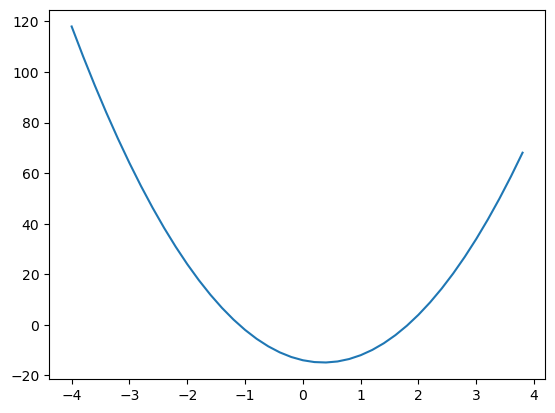

In [35]:
plt.plot(xs,ys)

In [37]:
h = 0.001
a = 0.3567
(f(a+h)-f(a))/h

0.0008000000004670937

In [39]:
class Value:
    def __init__(self , data , prev=() , op='' , label=''):
        self.data = data
        self.prev = set(prev)
        self.op = op
        self.label = label
        self.grad = 0
        self.backward = lambda : None


    def __repr__(self):
        return f"Value[ data = {self.data} , grad = {self.grad} ]"
    
    def __add__(self,other):
        other = other if isinstance(other , Value) else Value(other)
        out = Value(self.data + other.data , (self , other),'+')
        
        def backward():
            self.grad += out.grad
            other.grad += out.grad

        out.backward = backward
        return out
    
   

    
    def __mul__(self,other):
        other = other if isinstance(other , Value) else Value(other)
        out = Value(self.data * other.data,(self,other),'*')

        def backward():
            self.grad += out.grad * other.data
            other.grad += out.grad * self.data

        out.backward = backward
        return out
    
    def __radd__(self,other):
        return self+other
    
    def __rmul__(self,other):
        return self*other
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
        
        def backward():
            self.grad += (1 - t**2) * out.grad
        out.backward = backward
    
        return out
    

    def full_back(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
            for child in v.prev:
                build_topo(child)
            topo.append(v)
        
        build_topo(self)

        for node in reversed(topo):
            node.grad = 0
        self.grad = 1

        for node in reversed(topo):
            node.backward()

    
        

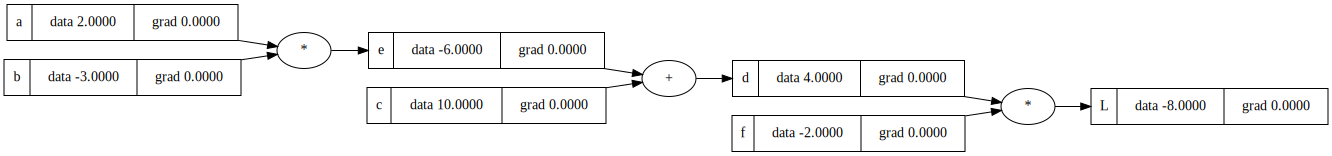

In [41]:
# testing

a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b
e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L1 = L.data

draw_dot(L)

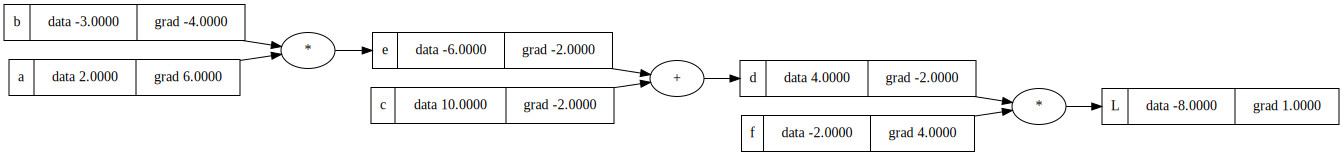

In [43]:
# full testing

a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b
e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L1 = L.data

L.grad = 1
L.backward()
d.backward()
e.backward()
draw_dot(L)

In [45]:
topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
    for child in v.prev:
        build_topo(child)
    topo.append(v)
    
build_topo(L)
topo


[Value[ data = -2.0 , grad = 4.0 ],
 Value[ data = 2.0 , grad = 6.0 ],
 Value[ data = -3.0 , grad = -4.0 ],
 Value[ data = -6.0 , grad = -2.0 ],
 Value[ data = 10.0 , grad = -2.0 ],
 Value[ data = 4.0 , grad = -2.0 ],
 Value[ data = -8.0 , grad = 1 ]]

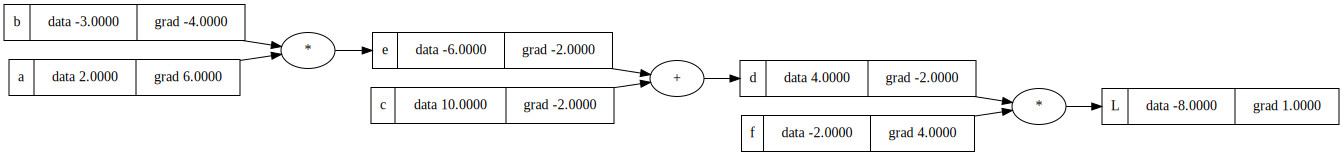

In [47]:
L.full_back()
draw_dot(L)

In [49]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

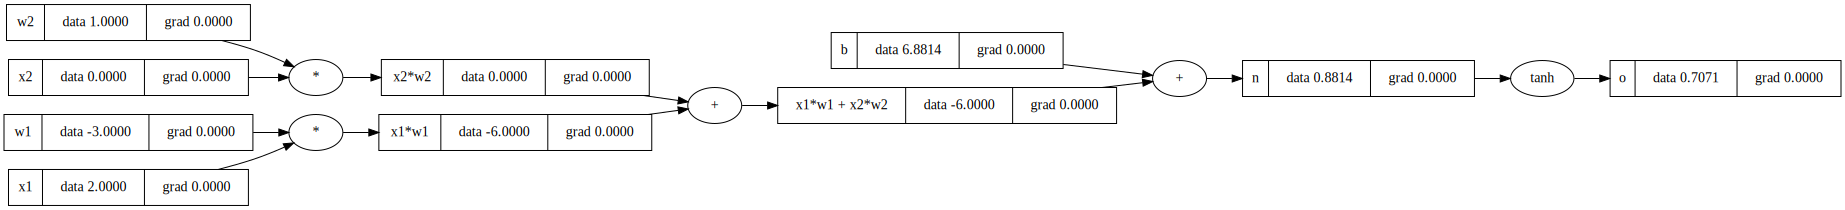

In [51]:
draw_dot(o)

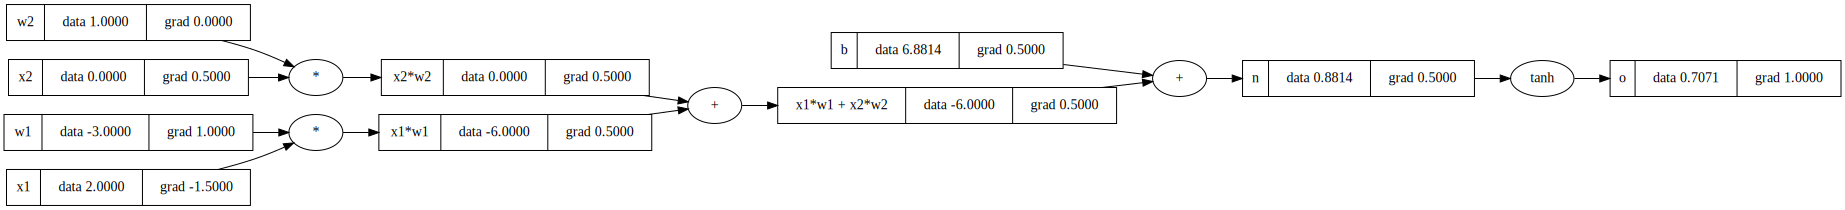

In [53]:
o.full_back()
draw_dot(o)

In [55]:
# Now builing an MLP -- neurons , layers and MLP (Multi Layer Perceptron)

import random


class Neuron:
    def __init__(self , nin ):
        self.w = [Value(random.uniform(-1,1),label='w') for _ in range(nin)]
        self.b = Value(random.uniform(-1,1),label='b')

    def __repr__(self):
        return f"Neuron object with weights {self.w} and bias {self.b}"

    def result(self , inputs):
        act = sum ((wi*xi for wi , xi in zip(self.w,inputs)) , self.b)
        out = act.tanh()
        return out


inputs = [1,2,3,4,5]
n = Neuron(5)
print (f"The neuron is {n}\nand its result with {inputs}\nis {n.result(inputs)}")
print("the above basically prints out a neuron with 5 weights and a bias  --- then the 5 inputs -- and the result(tanh appliead on activation)")
    

The neuron is Neuron object with weights [Value[ data = -0.006363688681990443 , grad = 0 ], Value[ data = -0.964856303447748 , grad = 0 ], Value[ data = -0.2257991250482958 , grad = 0 ], Value[ data = -0.30835696511461475 , grad = 0 ], Value[ data = -0.9993080545648152 , grad = 0 ]] and bias Value[ data = -0.7567840798885406 , grad = 0 ]
and its result with [1, 2, 3, 4, 5]
is Value[ data = -0.9999999908297803 , grad = 0 ]
the above basically prints out a neuron with 5 weights and a bias  --- then the 5 inputs -- and the result(tanh appliead on activation)


In [57]:
# a layer is a collection of neurons 
# nin -> num of neurons in prev layer
# nout -> num of nurons in this layer  

class Layer:
    def __init__(self, nin , nout):  
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def result(self , inputs):
        outs = [n.result(inputs) for n in self.neurons]
        return outs
    
inputs = [1,2,3]
l = Layer(3 , 2)
print("the neurons in this layer are (2) neurons")
for n in l.neurons:
    print(n)
print("\nthese give one output each:")
print(l.result(inputs))

the neurons in this layer are (2) neurons
Neuron object with weights [Value[ data = -0.7272046486682222 , grad = 0 ], Value[ data = -0.9773908226885126 , grad = 0 ], Value[ data = 0.3539884206788144 , grad = 0 ]] and bias Value[ data = 0.39693756140916947 , grad = 0 ]
Neuron object with weights [Value[ data = -0.728377309550047 , grad = 0 ], Value[ data = -0.9096190827700621 , grad = 0 ], Value[ data = -0.32422352468373195 , grad = 0 ]] and bias Value[ data = 0.8585739705585702 , grad = 0 ]

these give one output each:
[Value[ data = -0.840561388785588 , grad = 0 ], Value[ data = -0.9902952629411554 , grad = 0 ]]


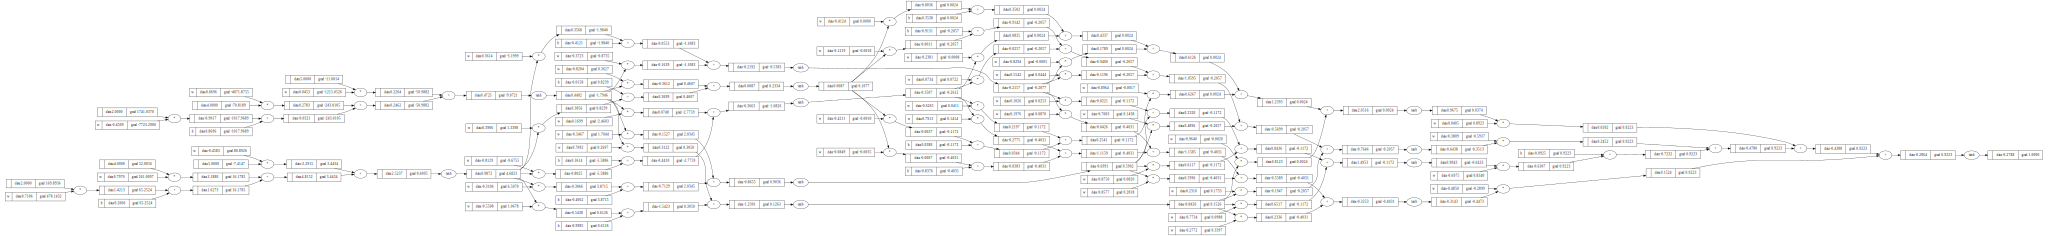

In [59]:
# an MLP is a collection of layers 
# nin -> num of neurons in input
# nout -> list of number of neurons in each layers

class MLP:
    def __init__(self,nin , nouts):
        self.num_neurons = [nin] + nouts
        # print(self.num_neurons)
        self.layers = [Layer(self.num_neurons[i] , self.num_neurons[i+1]) for i in range(len(nouts)) ]

    def result(self,x):
        for layer in self.layers:
            x = layer.result(x)
        return x if len(x)!=1 else x[0]

# now we first prepare each of the layers -- then take one input set , pass it to the first layer
# eg below layers are (first layer) - (4,2) then intermediates -- (2,5) , (5,8) , (8,4) and final -- (4,1) 
# in the intermediates - layer 1 has 2 neurons , layers 2 has 5 and so on
# first layer will take in the input as a vector of 4 numbers and each of the 2 neurons gives an output as a value object which serves as input to the next layer and so on until
# we get a single value object as the result in the final layer

inputs = [2,4,5]
mlp = MLP(4,[2,5,4,1])
out = mlp.result(inputs)
out.full_back()
draw_dot(out)

![SNOWFALL](MLP-visualisation-of-working.jpeg)

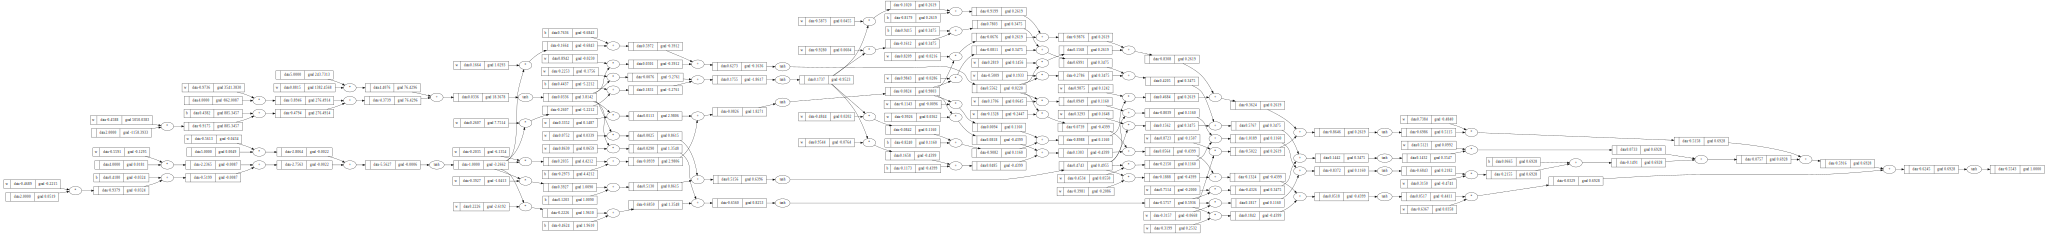

In [62]:
# putting it together - condensed

class Neuron:
    def __init__(self , nin ):
        self.w = [Value(random.uniform(-1,1),label='w') for _ in range(nin)]
        self.b = Value(random.uniform(-1,1),label='b')

    def result(self , inputs):
        act = sum ((wi*xi for wi , xi in zip(self.w,inputs)) , self.b)
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]

class Layer:
    def __init__(self, nin , nout):  
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def result(self , inputs):
        outs = [n.result(inputs) for n in self.neurons]
        return outs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
    
class MLP:
    def __init__(self,nin , nouts):
        self.num_neurons = [nin] + nouts
        self.layers = [Layer(self.num_neurons[i] , self.num_neurons[i+1]) for i in range(len(nouts)) ]

    def result(self,x):
        for layer in self.layers:
            x = layer.result(x)
        return x if len(x)!=1 else x[0]

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

inputs = [2,4,5]
mlp = MLP(4,[2,5,4,1])
out = mlp.result(inputs)
out.full_back()
draw_dot(out)

In [64]:
# now we train something fr0.01172
xs = [
  [2.0, 3.0, -1.0], 
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0], 
  [1.0, 1.0, -1.0], 
]

ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [66]:
mlp = MLP(3,[4,4,1])
ypred = [mlp.result(xi) for xi in xs]
ypred

[Value[ data = 0.6489462190235495 , grad = 0 ],
 Value[ data = 0.28683991616365845 , grad = 0 ],
 Value[ data = 0.883875555754402 , grad = 0 ],
 Value[ data = 0.6734536672320055 , grad = 0 ]]

In [68]:
differences_squared =  tuple((ypredi + -1*ysi ) * (ypredi + -1*ysi )  for ypredi,ysi in zip(ypred,ys))
differences_squared

(Value[ data = 0.12323875713786164 , grad = 0 ],
 Value[ data = 1.6559569698320913 , grad = 0 ],
 Value[ data = 3.548987109568957 , grad = 0 ],
 Value[ data = 0.1066325074442258 , grad = 0 ])

In [70]:
loss = sum((ypredi + -1*ysi ) * (ypredi + -1*ysi )  for ypredi,ysi in zip(ypred,ys))
loss

Value[ data = 5.434815343983136 , grad = 0 ]

In [72]:
# now to minimise loss using gradient descent

xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets


mlp = MLP(3,[4,4,1])

print(ypred)

print(ys)
print(loss)



[Value[ data = 0.6489462190235495 , grad = 0 ], Value[ data = 0.28683991616365845 , grad = 0 ], Value[ data = 0.883875555754402 , grad = 0 ], Value[ data = 0.6734536672320055 , grad = 0 ]]
[1.0, -1.0, -1.0, 1.0]
Value[ data = 5.434815343983136 , grad = 0 ]


In [74]:
for _ in range(20):
    ypred = [mlp.result(xi) for xi in xs]
    loss = sum((ypredi + -1*ysi ) * (ypredi + -1*ysi )  for ypredi,ysi in zip(ypred,ys))
    
    loss.full_back()

    for p in mlp.parameters():
        p.data += -0.008 * p.grad

    print(_+1 , loss  )
    

print(ypred)

1 Value[ data = 6.550587223254958 , grad = 1 ]
2 Value[ data = 4.0149854631005 , grad = 1 ]
3 Value[ data = 3.9042829675938657 , grad = 1 ]
4 Value[ data = 2.459932023074448 , grad = 1 ]
5 Value[ data = 1.4542705037076602 , grad = 1 ]
6 Value[ data = 4.021652972105134 , grad = 1 ]
7 Value[ data = 3.3521220436810406 , grad = 1 ]
8 Value[ data = 2.8511748532153574 , grad = 1 ]
9 Value[ data = 2.224158247452931 , grad = 1 ]
10 Value[ data = 1.2915741993479704 , grad = 1 ]
11 Value[ data = 0.8609090414495219 , grad = 1 ]
12 Value[ data = 0.657507777037816 , grad = 1 ]
13 Value[ data = 0.5221609807158557 , grad = 1 ]
14 Value[ data = 0.42801113910906596 , grad = 1 ]
15 Value[ data = 0.35468236126022157 , grad = 1 ]
16 Value[ data = 0.2953185795600551 , grad = 1 ]
17 Value[ data = 0.24370134740077345 , grad = 1 ]
18 Value[ data = 0.1975619601189586 , grad = 1 ]
19 Value[ data = 0.1645572392973406 , grad = 1 ]
20 Value[ data = 0.1365666313307401 , grad = 1 ]
[Value[ data = 0.818378450405778 ,

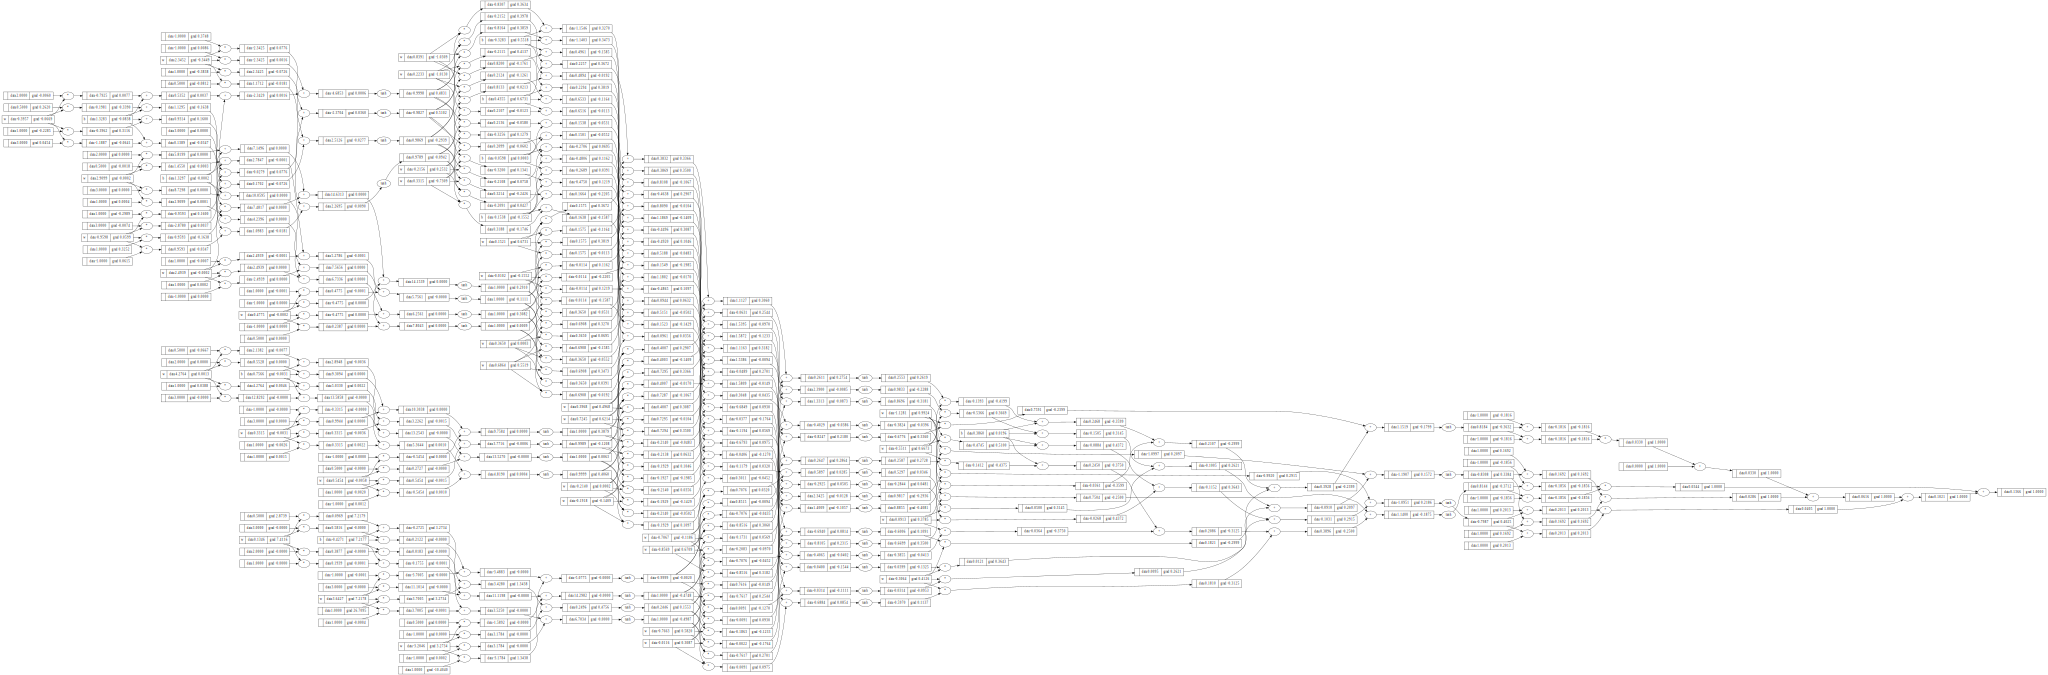

In [76]:
draw_dot(loss)
# will notice quite low gradients on everything now :) --> approaching a minimas